In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import d3rlpy
import torch
import numpy as np
from matplotlib import pyplot as plt
from makeSeaquestdata import load_seaquest_dataset, make_seaquest_testset
from load_model import load_seaquest_model
from model import make_episodes, fit_discrete_sac, fit_per_cluster
from utils import create_trajectories, get_trajectory_embedding, perform_clustering_and_plot, trajectory_attributions_sq, set_seeds, print_results_sq
from encoder import CustomCNNFactory

c:\Users\jortv\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set device and random seed
device = set_seeds(seed=0)

# Set data and test sizes
data_size, test_size = 100, 10

In [21]:
# Load Seaquest dataset
seaquestdata, sq_env = load_seaquest_dataset(env_name='Qbert', size=data_size+test_size)
print(len(seaquestdata["terminals"]))
print(np.unique(seaquestdata["terminals"], return_counts=True))

decompressing data...
Dataset loaded
130756
Dataset extracted with 130756 samples.
Information about the dataset:
Observation shape:  (130756, 4, 84, 84)
Action shape:  (130756,)
Reward shape:  (130756,)
Terminal shape:  (130756,)
Action space:  6
Observation space:  (84, 84)
Number of terminal states is... 109
Environment 'ALE/Qbert-ram-v5' initialized.
130756
(array([0, 1], dtype=uint8), array([130647,    109], dtype=int64))


In [22]:
# Load pre-trained encoders
pre_trained_encoder_seaquest = load_seaquest_model("decision_transformer_atari/checkpoints/Qbert_123.pth", vocab_size=6, block_size=90, timesteps=3901, seed=0)

# Create Seaquest test set
seaquestdata, test_observation_sq = make_seaquest_testset(seaquestdata, data_size, test_size)

In [24]:
len(seaquestdata["terminals"])

120564

In [7]:
# Create trajectories and obtain embeddings for Seaquest data
final_obs_sq, final_act_sq, final_rew_sq, _ = create_trajectories(
    seaquestdata["observations"], seaquestdata["actions"], 
    seaquestdata["rewards"], seaquestdata["terminals"], trajectory_length=30
)
trajectory_embedding_seaquest = get_trajectory_embedding(
    pre_trained_encoder_seaquest, final_obs_sq, final_act_sq, final_rew_sq, 
    is_seaquest=True, device=device
)

Processing sub'trajectories: 100%|██████████| 120564/120564 [00:02<00:00, 41739.86it/s]
c:\Users\jortv\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\cuda\amp\grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Processing trajectories:   0%|          | 0/4069 [00:00<?, ?it/s]c:\Users\jortv\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Processing trajectories: 100%|██████████| 4069/4069 [00:56<00:00, 72.66it/s]


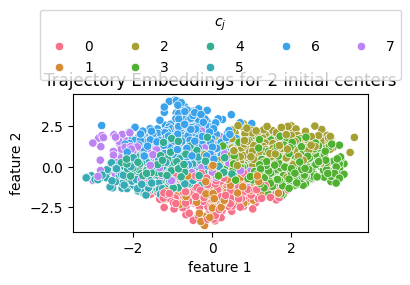

In [8]:
# Perform clustering on Seaquest data
clusters_seaquest, _ = perform_clustering_and_plot(trajectory_embedding_seaquest.detach().cpu().numpy(), 2, 8, ccore=True, plot=True)

In [25]:
 # Train Seaquest model with DiscreteSAC
print('#' * 100)
print("Training Seaquest with DiscreteSAC...")
list_episodes_sq = make_episodes(final_obs_sq, final_act_sq, final_rew_sq, 6)
sac_sq = fit_discrete_sac(list_episodes_sq, n_steps=1000, n_steps_per_epoch=100, device=device)

####################################################################################################
Training Seaquest with DiscreteSAC...
2024-04-11 12:25:02 [debug    ] RandomIterator is selected.   
2024-04-11 12:25:02 [info     ] Directory is created at d3rlpy_logs\DiscreteSAC_20240411122502
2024-04-11 12:25:02 [debug    ] Fitting scaler...              scaler=pixel
2024-04-11 12:25:02 [debug    ] Building models...            
2024-04-11 12:25:02 [debug    ] Models have been built.       
2024-04-11 12:25:02 [info     ] Parameters are saved to d3rlpy_logs\DiscreteSAC_20240411122502\params.json params={'action_scaler': None, 'actor_encoder_factory': {'type': 'custom', 'params': {'feature_size': 128}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 0.0001, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'custom', 'params': {'feature_size': 128}}, 'critic_learning_rate': 0.0003, 'cr

Epoch 1/10: 100%|██████████| 100/100 [00:27<00:00,  3.68it/s, temp_loss=0.0338, temp=0.986, critic_loss=0.558, actor_loss=-3.3]


2024-04-11 12:25:29 [info     ] DiscreteSAC_20240411122502: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.0382515549659729, 'time_algorithm_update': 0.2320858645439148, 'temp_loss': 0.03389710556715727, 'temp': 0.9850431913137436, 'critic_loss': 0.5283539451658725, 'actor_loss': -3.315333238840103, 'time_step': 0.2704769515991211} step=100
2024-04-11 12:25:29 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411122502\model_100.pt


Epoch 2/10: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s, temp_loss=0.0341, temp=0.957, critic_loss=0.199, actor_loss=-3.47]


2024-04-11 12:25:55 [info     ] DiscreteSAC_20240411122502: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.022251091003417968, 'time_algorithm_update': 0.22785846948623656, 'temp_loss': 0.034065518677234646, 'temp': 0.9556939148902893, 'critic_loss': 0.19817493870854377, 'actor_loss': -3.467290267944336, 'time_step': 0.25026084423065187} step=200
2024-04-11 12:25:55 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411122502\model_200.pt


Epoch 3/10: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s, temp_loss=0.0332, temp=0.929, critic_loss=0.197, actor_loss=-3.38]


2024-04-11 12:26:19 [info     ] DiscreteSAC_20240411122502: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.01565129280090332, 'time_algorithm_update': 0.22278197050094606, 'temp_loss': 0.033191676922142505, 'temp': 0.9277392512559891, 'critic_loss': 0.19757920295000075, 'actor_loss': -3.370907440185547, 'time_step': 0.23856230020523073} step=300
2024-04-11 12:26:19 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411122502\model_300.pt


Epoch 4/10: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s, temp_loss=0.0323, temp=0.902, critic_loss=0.196, actor_loss=-3.28]


2024-04-11 12:26:42 [info     ] DiscreteSAC_20240411122502: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.012760365009307861, 'time_algorithm_update': 0.2202434539794922, 'temp_loss': 0.0322535889968276, 'temp': 0.9011114472150803, 'critic_loss': 0.19468740463256837, 'actor_loss': -3.2777768301963808, 'time_step': 0.23319133281707763} step=400
2024-04-11 12:26:42 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411122502\model_400.pt


Epoch 5/10: 100%|██████████| 100/100 [00:22<00:00,  4.44it/s, temp_loss=0.0314, temp=0.877, critic_loss=0.18, actor_loss=-3.2] 


2024-04-11 12:27:05 [info     ] DiscreteSAC_20240411122502: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.009328234195709228, 'time_algorithm_update': 0.21493662118911744, 'temp_loss': 0.031329333558678625, 'temp': 0.8756742417812348, 'critic_loss': 0.17945538431406022, 'actor_loss': -3.1933492326736452, 'time_step': 0.22439301490783692} step=500
2024-04-11 12:27:05 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411122502\model_500.pt


Epoch 6/10: 100%|██████████| 100/100 [00:22<00:00,  4.52it/s, temp_loss=0.0305, temp=0.852, critic_loss=0.174, actor_loss=-3.1]


2024-04-11 12:27:27 [info     ] DiscreteSAC_20240411122502: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.006875262260437011, 'time_algorithm_update': 0.21322214841842652, 'temp_loss': 0.030456789191812276, 'temp': 0.8513084626197815, 'critic_loss': 0.1737719914317131, 'actor_loss': -3.0961987447738646, 'time_step': 0.22021092414855958} step=600
2024-04-11 12:27:27 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411122502\model_600.pt


Epoch 7/10: 100%|██████████| 100/100 [00:22<00:00,  4.46it/s, temp_loss=0.0297, temp=0.829, critic_loss=0.168, actor_loss=-3.01]


2024-04-11 12:27:49 [info     ] DiscreteSAC_20240411122502: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.006194148063659668, 'time_algorithm_update': 0.21683507204055785, 'temp_loss': 0.02962005265057087, 'temp': 0.8279299437999725, 'critic_loss': 0.16822144851088525, 'actor_loss': -3.0100013637542724, 'time_step': 0.22317940950393678} step=700
2024-04-11 12:27:49 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411122502\model_700.pt


Epoch 8/10: 100%|██████████| 100/100 [00:23<00:00,  4.33it/s, temp_loss=0.0289, temp=0.806, critic_loss=0.163, actor_loss=-2.93]


2024-04-11 12:28:12 [info     ] DiscreteSAC_20240411122502: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.005626542568206787, 'time_algorithm_update': 0.22447448015213012, 'temp_loss': 0.028825732432305812, 'temp': 0.8054620987176895, 'critic_loss': 0.16280348867177963, 'actor_loss': -2.922876832485199, 'time_step': 0.23024832487106323} step=800
2024-04-11 12:28:12 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411122502\model_800.pt


Epoch 9/10: 100%|██████████| 100/100 [00:22<00:00,  4.43it/s, temp_loss=0.0281, temp=0.785, critic_loss=0.149, actor_loss=-2.86]


2024-04-11 12:28:35 [info     ] DiscreteSAC_20240411122502: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.005366268157958984, 'time_algorithm_update': 0.21925015926361083, 'temp_loss': 0.02805879384279251, 'temp': 0.7838459885120392, 'critic_loss': 0.14985240250825882, 'actor_loss': -2.856379885673523, 'time_step': 0.224728262424469} step=900
2024-04-11 12:28:35 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411122502\model_900.pt


Epoch 10/10: 100%|██████████| 100/100 [00:22<00:00,  4.41it/s, temp_loss=0.0273, temp=0.764, critic_loss=0.146, actor_loss=-2.79]


2024-04-11 12:28:58 [info     ] DiscreteSAC_20240411122502: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.00499398946762085, 'time_algorithm_update': 0.2206239366531372, 'temp_loss': 0.027300174236297606, 'temp': 0.7630419772863388, 'critic_loss': 0.14586203776299952, 'actor_loss': -2.7852153372764588, 'time_step': 0.2257768201828003} step=1000
2024-04-11 12:28:58 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411122502\model_1000.pt


In [26]:
# Compute all possible permutations of clusters
print('#' * 100)
print("Compute all possible permutations of clusters")
feature_size = 128
custom_encoder_actor = CustomCNNFactory(feature_size)
custom_encoder_critic = CustomCNNFactory(feature_size)

model_params_sq = {
    'actor_learning_rate': 3e-4,
    'critic_learning_rate': 3e-4,
    'temp_learning_rate': 3e-4,
    'batch_size': 256,
    'actor_encoder_factory': custom_encoder_actor,
    'critic_encoder_factory': custom_encoder_critic,
    'scaler': 'pixel',
    'use_gpu': True if device == 'cuda' else False
}

####################################################################################################
Compute all possible permutations of clusters


In [28]:
# Fit models per cluster for Seaquest data
models_sq, result_data_combinations_sq = fit_per_cluster(
    model=sac_sq, 
    model_class=d3rlpy.algos.DiscreteSAC,
    model_params=model_params_sq,
    data_embedding=trajectory_embedding_seaquest,
    list_episodes=list_episodes_sq,
    clusters=clusters_seaquest,
    trajectory_embedding=trajectory_embedding_seaquest,
    test_observations=test_observation_sq
)

----------------------------------------------------------------------------------------------------
Cluster 1 has 527 trajectories out of 4069
----------------------------------------------------------------------------------------------------
2024-04-11 12:32:40 [debug    ] RandomIterator is selected.   
2024-04-11 12:32:40 [info     ] Directory is created at d3rlpy_logs\DiscreteSAC_20240411123240
2024-04-11 12:32:40 [debug    ] Fitting scaler...              scaler=pixel
2024-04-11 12:32:40 [debug    ] Building models...            
2024-04-11 12:32:40 [debug    ] Models have been built.       
2024-04-11 12:32:40 [info     ] Parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123240\params.json params={'action_scaler': None, 'actor_encoder_factory': {'type': 'custom', 'params': {'feature_size': 128}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 0.0001, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_

Epoch 1/10: 100%|██████████| 100/100 [00:22<00:00,  4.44it/s, temp_loss=0.0343, temp=0.986, critic_loss=0.551, actor_loss=-3.3]


2024-04-11 12:33:02 [info     ] DiscreteSAC_20240411123240: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.004773836135864257, 'time_algorithm_update': 0.2192040228843689, 'temp_loss': 0.03432794595137238, 'temp': 0.9850668317079544, 'critic_loss': 0.5222520339488983, 'actor_loss': -3.322649666070938, 'time_step': 0.22411720037460328} step=100
2024-04-11 12:33:02 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123240\model_100.pt


Epoch 2/10: 100%|██████████| 100/100 [00:22<00:00,  4.40it/s, temp_loss=0.0341, temp=0.957, critic_loss=0.207, actor_loss=-3.47]


2024-04-11 12:33:25 [info     ] DiscreteSAC_20240411123240: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.004783375263214111, 'time_algorithm_update': 0.22150617122650146, 'temp_loss': 0.03411090295761823, 'temp': 0.9558865803480149, 'critic_loss': 0.20603019192814828, 'actor_loss': -3.4674608850479127, 'time_step': 0.226424663066864} step=200
2024-04-11 12:33:25 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123240\model_200.pt


Epoch 3/10: 100%|██████████| 100/100 [00:23<00:00,  4.31it/s, temp_loss=0.0333, temp=0.929, critic_loss=0.2, actor_loss=-3.39] 


2024-04-11 12:33:49 [info     ] DiscreteSAC_20240411123240: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.004747602939605713, 'time_algorithm_update': 0.22645354509353638, 'temp_loss': 0.03321691818535328, 'temp': 0.9281019532680511, 'critic_loss': 0.19983687236905098, 'actor_loss': -3.38224668264389, 'time_step': 0.23136618614196777} step=300
2024-04-11 12:33:49 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123240\model_300.pt


Epoch 4/10: 100%|██████████| 100/100 [00:23<00:00,  4.34it/s, temp_loss=0.0323, temp=0.903, critic_loss=0.188, actor_loss=-3.29]


2024-04-11 12:34:12 [info     ] DiscreteSAC_20240411123240: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.00481987714767456, 'time_algorithm_update': 0.2247459363937378, 'temp_loss': 0.03226520612835884, 'temp': 0.9015777677297592, 'critic_loss': 0.18884839355945587, 'actor_loss': -3.283771870136261, 'time_step': 0.2297351574897766} step=400
2024-04-11 12:34:12 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123240\model_400.pt


Epoch 5/10: 100%|██████████| 100/100 [00:22<00:00,  4.47it/s, temp_loss=0.0314, temp=0.877, critic_loss=0.181, actor_loss=-3.18]


2024-04-11 12:34:34 [info     ] DiscreteSAC_20240411123240: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.00470059871673584, 'time_algorithm_update': 0.21789936304092408, 'temp_loss': 0.03136826252564788, 'temp': 0.8762026274204254, 'critic_loss': 0.18092343874275685, 'actor_loss': -3.172435235977173, 'time_step': 0.22271632194519042} step=500
2024-04-11 12:34:34 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123240\model_500.pt


Epoch 6/10: 100%|██████████| 100/100 [00:22<00:00,  4.50it/s, temp_loss=0.0305, temp=0.853, critic_loss=0.175, actor_loss=-3.09]


2024-04-11 12:34:56 [info     ] DiscreteSAC_20240411123240: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.004891357421875, 'time_algorithm_update': 0.21631841421127318, 'temp_loss': 0.030471254121512175, 'temp': 0.8518791449069977, 'critic_loss': 0.17493935838341712, 'actor_loss': -3.0828743386268616, 'time_step': 0.22136988878250122} step=600
2024-04-11 12:34:56 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123240\model_600.pt


Epoch 7/10: 100%|██████████| 100/100 [00:22<00:00,  4.39it/s, temp_loss=0.0297, temp=0.83, critic_loss=0.163, actor_loss=-3]   


2024-04-11 12:35:19 [info     ] DiscreteSAC_20240411123240: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.004900448322296143, 'time_algorithm_update': 0.22151399850845338, 'temp_loss': 0.029668427370488644, 'temp': 0.8285145151615143, 'critic_loss': 0.16372749738395215, 'actor_loss': -2.999392125606537, 'time_step': 0.22656691074371338} step=700
2024-04-11 12:35:19 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123240\model_700.pt


Epoch 8/10: 100%|██████████| 100/100 [00:23<00:00,  4.25it/s, temp_loss=0.0289, temp=0.807, critic_loss=0.16, actor_loss=-2.93]


2024-04-11 12:35:43 [info     ] DiscreteSAC_20240411123240: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.00499924898147583, 'time_algorithm_update': 0.2289299488067627, 'temp_loss': 0.028853779844939708, 'temp': 0.8060561013221741, 'critic_loss': 0.15931670121848585, 'actor_loss': -2.9253438997268675, 'time_step': 0.2341054606437683} step=800
2024-04-11 12:35:43 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123240\model_800.pt


Epoch 9/10: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s, temp_loss=0.0281, temp=0.785, critic_loss=0.156, actor_loss=-2.85]


2024-04-11 12:36:07 [info     ] DiscreteSAC_20240411123240: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.005078840255737305, 'time_algorithm_update': 0.23521217346191406, 'temp_loss': 0.02809484224766493, 'temp': 0.7844472324848175, 'critic_loss': 0.15500188685953617, 'actor_loss': -2.848814833164215, 'time_step': 0.24043712854385377} step=900
2024-04-11 12:36:07 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123240\model_900.pt


Epoch 10/10: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s, temp_loss=0.0274, temp=0.765, critic_loss=0.152, actor_loss=-2.79]


2024-04-11 12:36:31 [info     ] DiscreteSAC_20240411123240: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.004974904060363769, 'time_algorithm_update': 0.23397639513015747, 'temp_loss': 0.027338296324014664, 'temp': 0.7636377257108689, 'critic_loss': 0.15130096577107907, 'actor_loss': -2.7853570318222047, 'time_step': 0.23909459590911866} step=1000
2024-04-11 12:36:31 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123240\model_1000.pt
----------------------------------------------------------------------------------------------------
Cluster 2 has 305 trajectories out of 4069
----------------------------------------------------------------------------------------------------
2024-04-11 12:36:31 [debug    ] RandomIterator is selected.   
2024-04-11 12:36:31 [info     ] Directory is created at d3rlpy_logs\DiscreteSAC_20240411123631
2024-04-11 12:36:31 [debug    ] Fitting scaler...              scaler=pixel
2024-04-11 12:36:31 [debug    ] Building m

Epoch 1/10: 100%|██████████| 100/100 [00:22<00:00,  4.38it/s, temp_loss=0.0339, temp=0.986, critic_loss=0.58, actor_loss=-3.31]


2024-04-11 12:36:54 [info     ] DiscreteSAC_20240411123631: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.004971988201141357, 'time_algorithm_update': 0.2219346022605896, 'temp_loss': 0.03392760107293725, 'temp': 0.9851048827171326, 'critic_loss': 0.5481899137794971, 'actor_loss': -3.326339818239212, 'time_step': 0.2270553755760193} step=100
2024-04-11 12:36:54 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123631\model_100.pt


Epoch 2/10: 100%|██████████| 100/100 [00:22<00:00,  4.37it/s, temp_loss=0.034, temp=0.957, critic_loss=0.21, actor_loss=-3.48] 


2024-04-11 12:37:17 [info     ] DiscreteSAC_20240411123631: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.004923489093780518, 'time_algorithm_update': 0.2230113434791565, 'temp_loss': 0.0339732526242733, 'temp': 0.9558462715148925, 'critic_loss': 0.2092630733549595, 'actor_loss': -3.473616223335266, 'time_step': 0.22808778285980225} step=200
2024-04-11 12:37:17 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123631\model_200.pt


Epoch 3/10: 100%|██████████| 100/100 [00:22<00:00,  4.35it/s, temp_loss=0.0332, temp=0.929, critic_loss=0.191, actor_loss=-3.39]


2024-04-11 12:37:40 [info     ] DiscreteSAC_20240411123631: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.004795458316802979, 'time_algorithm_update': 0.22376079797744752, 'temp_loss': 0.03316708356142044, 'temp': 0.927926653623581, 'critic_loss': 0.19228579208254815, 'actor_loss': -3.38588636636734, 'time_step': 0.22870768308639527} step=300
2024-04-11 12:37:40 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123631\model_300.pt


Epoch 4/10: 100%|██████████| 100/100 [00:23<00:00,  4.33it/s, temp_loss=0.0323, temp=0.902, critic_loss=0.189, actor_loss=-3.3]


2024-04-11 12:38:03 [info     ] DiscreteSAC_20240411123631: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.004967834949493408, 'time_algorithm_update': 0.22457698345184327, 'temp_loss': 0.03227284155786037, 'temp': 0.9012877666950225, 'critic_loss': 0.18728796690702437, 'actor_loss': -3.2997077655792237, 'time_step': 0.22971080780029296} step=400
2024-04-11 12:38:03 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123631\model_400.pt


Epoch 5/10: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s, temp_loss=0.0313, temp=0.877, critic_loss=0.184, actor_loss=-3.21]


2024-04-11 12:38:27 [info     ] DiscreteSAC_20240411123631: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.004941329956054687, 'time_algorithm_update': 0.23174343824386598, 'temp_loss': 0.03129345886409283, 'temp': 0.8758334314823151, 'critic_loss': 0.18340468615293504, 'actor_loss': -3.2064618682861328, 'time_step': 0.23686944246292113} step=500
2024-04-11 12:38:27 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123631\model_500.pt


Epoch 6/10: 100%|██████████| 100/100 [00:23<00:00,  4.23it/s, temp_loss=0.0305, temp=0.853, critic_loss=0.179, actor_loss=-3.13]


2024-04-11 12:38:50 [info     ] DiscreteSAC_20240411123631: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.004836788177490234, 'time_algorithm_update': 0.23039265155792235, 'temp_loss': 0.030455888118594884, 'temp': 0.8514921224117279, 'critic_loss': 0.17718010887503624, 'actor_loss': -3.121928071975708, 'time_step': 0.23537661075592042} step=600
2024-04-11 12:38:50 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123631\model_600.pt


Epoch 7/10: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s, temp_loss=0.0297, temp=0.829, critic_loss=0.161, actor_loss=-3.03]


2024-04-11 12:39:15 [info     ] DiscreteSAC_20240411123631: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.005045778751373291, 'time_algorithm_update': 0.23470845937728882, 'temp_loss': 0.029666885323822497, 'temp': 0.8280799257755279, 'critic_loss': 0.16222196698188782, 'actor_loss': -3.0285299611091614, 'time_step': 0.23988964796066284} step=700
2024-04-11 12:39:15 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123631\model_700.pt


Epoch 8/10: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s, temp_loss=0.0289, temp=0.807, critic_loss=0.165, actor_loss=-2.95]


2024-04-11 12:39:40 [info     ] DiscreteSAC_20240411123631: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.005264894962310791, 'time_algorithm_update': 0.24495359659194946, 'temp_loss': 0.0288478035479784, 'temp': 0.8055795508623124, 'critic_loss': 0.16487706035375596, 'actor_loss': -2.9418191003799437, 'time_step': 0.25035690784454345} step=800
2024-04-11 12:39:40 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123631\model_800.pt


Epoch 9/10: 100%|██████████| 100/100 [00:24<00:00,  4.07it/s, temp_loss=0.0281, temp=0.785, critic_loss=0.159, actor_loss=-2.87]


2024-04-11 12:40:04 [info     ] DiscreteSAC_20240411123631: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.005263261795043946, 'time_algorithm_update': 0.23939136028289795, 'temp_loss': 0.02805593650788069, 'temp': 0.7839544451236725, 'critic_loss': 0.15820444718003274, 'actor_loss': -2.865057444572449, 'time_step': 0.24481647491455077} step=900
2024-04-11 12:40:04 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123631\model_900.pt


Epoch 10/10: 100%|██████████| 100/100 [00:24<00:00,  4.05it/s, temp_loss=0.0274, temp=0.764, critic_loss=0.148, actor_loss=-2.8]


2024-04-11 12:40:29 [info     ] DiscreteSAC_20240411123631: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.00555419921875, 'time_algorithm_update': 0.2404634928703308, 'temp_loss': 0.027327351942658423, 'temp': 0.7631373596191406, 'critic_loss': 0.14796052098274232, 'actor_loss': -2.7965752363204954, 'time_step': 0.2461618661880493} step=1000
2024-04-11 12:40:29 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411123631\model_1000.pt
----------------------------------------------------------------------------------------------------
Cluster 3 has 515 trajectories out of 4069
----------------------------------------------------------------------------------------------------
2024-04-11 12:40:29 [debug    ] RandomIterator is selected.   
2024-04-11 12:40:29 [info     ] Directory is created at d3rlpy_logs\DiscreteSAC_20240411124029
2024-04-11 12:40:29 [debug    ] Fitting scaler...              scaler=pixel
2024-04-11 12:40:29 [debug    ] Building models.

Epoch 1/10: 100%|██████████| 100/100 [00:23<00:00,  4.22it/s, temp_loss=0.0284, temp=0.989, critic_loss=0.594, actor_loss=-3.26]


2024-04-11 12:40:53 [info     ] DiscreteSAC_20240411124029: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.005534420013427735, 'time_algorithm_update': 0.22996951818466185, 'temp_loss': 0.029012591922655703, 'temp': 0.9878325092792511, 'critic_loss': 0.5600282630324364, 'actor_loss': -3.2826667273044587, 'time_step': 0.23563464403152465} step=100
2024-04-11 12:40:53 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124029\model_100.pt


Epoch 2/10: 100%|██████████| 100/100 [00:23<00:00,  4.25it/s, temp_loss=0.0343, temp=0.96, critic_loss=0.201, actor_loss=-3.49]


2024-04-11 12:41:17 [info     ] DiscreteSAC_20240411124029: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.0053924345970153805, 'time_algorithm_update': 0.22890496253967285, 'temp_loss': 0.03427013523876667, 'temp': 0.9587229895591736, 'critic_loss': 0.202654599994421, 'actor_loss': -3.4804973888397215, 'time_step': 0.23448075771331786} step=200
2024-04-11 12:41:17 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124029\model_200.pt


Epoch 3/10: 100%|██████████| 100/100 [00:24<00:00,  4.11it/s, temp_loss=0.0333, temp=0.931, critic_loss=0.201, actor_loss=-3.39]


2024-04-11 12:41:41 [info     ] DiscreteSAC_20240411124029: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.005301699638366699, 'time_algorithm_update': 0.23646209716796876, 'temp_loss': 0.03329201959073544, 'temp': 0.9302443504333496, 'critic_loss': 0.2009887194633484, 'actor_loss': -3.3910594034194945, 'time_step': 0.24190048217773438} step=300
2024-04-11 12:41:41 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124029\model_300.pt


Epoch 4/10: 100%|██████████| 100/100 [00:24<00:00,  4.07it/s, temp_loss=0.0323, temp=0.904, critic_loss=0.196, actor_loss=-3.3]


2024-04-11 12:42:05 [info     ] DiscreteSAC_20240411124029: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.005199353694915771, 'time_algorithm_update': 0.23904921770095824, 'temp_loss': 0.032285661064088346, 'temp': 0.9033266460895538, 'critic_loss': 0.19703326106071473, 'actor_loss': -3.30029531955719, 'time_step': 0.24442086219787598} step=400
2024-04-11 12:42:06 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124029\model_400.pt


Epoch 5/10: 100%|██████████| 100/100 [00:23<00:00,  4.17it/s, temp_loss=0.0314, temp=0.879, critic_loss=0.19, actor_loss=-3.22]


2024-04-11 12:42:29 [info     ] DiscreteSAC_20240411124029: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.0051195621490478516, 'time_algorithm_update': 0.23344022035598755, 'temp_loss': 0.03136399468407035, 'temp': 0.8776982790231704, 'critic_loss': 0.1897902497649193, 'actor_loss': -3.2184045338630676, 'time_step': 0.23874958515167236} step=500
2024-04-11 12:42:30 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124029\model_500.pt


Epoch 6/10: 100%|██████████| 100/100 [00:24<00:00,  4.05it/s, temp_loss=0.0305, temp=0.854, critic_loss=0.182, actor_loss=-3.13]


2024-04-11 12:42:54 [info     ] DiscreteSAC_20240411124029: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.00495729923248291, 'time_algorithm_update': 0.24077053785324096, 'temp_loss': 0.03051165582612157, 'temp': 0.8531722939014434, 'critic_loss': 0.18345766194164753, 'actor_loss': -3.1240540075302126, 'time_step': 0.24590869665145873} step=600
2024-04-11 12:42:54 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124029\model_600.pt


Epoch 7/10: 100%|██████████| 100/100 [00:25<00:00,  3.91it/s, temp_loss=0.0297, temp=0.831, critic_loss=0.17, actor_loss=-3.04]


2024-04-11 12:43:20 [info     ] DiscreteSAC_20240411124029: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.005581443309783936, 'time_algorithm_update': 0.2488744354248047, 'temp_loss': 0.029658577647060157, 'temp': 0.8296540540456772, 'critic_loss': 0.17027077630162238, 'actor_loss': -3.0356294178962706, 'time_step': 0.25460115671157835} step=700
2024-04-11 12:43:20 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124029\model_700.pt


Epoch 8/10: 100%|██████████| 100/100 [00:26<00:00,  3.75it/s, temp_loss=0.0289, temp=0.808, critic_loss=0.162, actor_loss=-2.95]


2024-04-11 12:43:47 [info     ] DiscreteSAC_20240411124029: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.00708728551864624, 'time_algorithm_update': 0.2583664870262146, 'temp_loss': 0.028844699151813983, 'temp': 0.8070816391706467, 'critic_loss': 0.1615082247555256, 'actor_loss': -2.949631850719452, 'time_step': 0.265581750869751} step=800
2024-04-11 12:43:47 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124029\model_800.pt


Epoch 9/10: 100%|██████████| 100/100 [00:26<00:00,  3.70it/s, temp_loss=0.0281, temp=0.786, critic_loss=0.157, actor_loss=-2.87]


2024-04-11 12:44:14 [info     ] DiscreteSAC_20240411124029: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.006895713806152344, 'time_algorithm_update': 0.2615437388420105, 'temp_loss': 0.028091465197503565, 'temp': 0.7853788125514984, 'critic_loss': 0.15730699136853218, 'actor_loss': -2.8712687826156618, 'time_step': 0.26862244606018065} step=900
2024-04-11 12:44:14 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124029\model_900.pt


Epoch 10/10: 100%|██████████| 100/100 [00:27<00:00,  3.60it/s, temp_loss=0.0274, temp=0.765, critic_loss=0.143, actor_loss=-2.81]


2024-04-11 12:44:41 [info     ] DiscreteSAC_20240411124029: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.006692140102386474, 'time_algorithm_update': 0.26938424110412595, 'temp_loss': 0.027353242281824352, 'temp': 0.7644810020923615, 'critic_loss': 0.14269653648138048, 'actor_loss': -2.802082750797272, 'time_step': 0.27628796339035033} step=1000
2024-04-11 12:44:41 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124029\model_1000.pt
----------------------------------------------------------------------------------------------------
Cluster 4 has 657 trajectories out of 4069
----------------------------------------------------------------------------------------------------
2024-04-11 12:44:42 [debug    ] RandomIterator is selected.   
2024-04-11 12:44:42 [info     ] Directory is created at d3rlpy_logs\DiscreteSAC_20240411124442
2024-04-11 12:44:42 [debug    ] Fitting scaler...              scaler=pixel
2024-04-11 12:44:42 [debug    ] Building mo

Epoch 1/10: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, temp_loss=0.0255, temp=0.99, critic_loss=0.554, actor_loss=-3.29]


2024-04-11 12:45:08 [info     ] DiscreteSAC_20240411124442: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.0065208816528320316, 'time_algorithm_update': 0.2546596121788025, 'temp_loss': 0.026308969513047488, 'temp': 0.9889513224363327, 'critic_loss': 0.5247121277451515, 'actor_loss': -3.311009855270386, 'time_step': 0.2613620972633362} step=100
2024-04-11 12:45:08 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124442\model_100.pt


Epoch 2/10: 100%|██████████| 100/100 [00:25<00:00,  3.94it/s, temp_loss=0.0338, temp=0.961, critic_loss=0.216, actor_loss=-3.49]


2024-04-11 12:45:33 [info     ] DiscreteSAC_20240411124442: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.00627730131149292, 'time_algorithm_update': 0.24578884363174439, 'temp_loss': 0.03373979929834604, 'temp': 0.9598021894693375, 'critic_loss': 0.2154712088406086, 'actor_loss': -3.4869877171516417, 'time_step': 0.25227455139160154} step=200
2024-04-11 12:45:33 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124442\model_200.pt


Epoch 3/10: 100%|██████████| 100/100 [00:32<00:00,  3.03it/s, temp_loss=0.033, temp=0.932, critic_loss=0.201, actor_loss=-3.38]


2024-04-11 12:46:06 [info     ] DiscreteSAC_20240411124442: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.007364130020141602, 'time_algorithm_update': 0.320502405166626, 'temp_loss': 0.03293521169573069, 'temp': 0.9308557552099228, 'critic_loss': 0.20021785482764243, 'actor_loss': -3.378385052680969, 'time_step': 0.32811389207839964} step=300
2024-04-11 12:46:06 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124442\model_300.pt


Epoch 4/10: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s, temp_loss=0.032, temp=0.905, critic_loss=0.191, actor_loss=-3.29]


2024-04-11 12:46:45 [info     ] DiscreteSAC_20240411124442: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.007971508502960205, 'time_algorithm_update': 0.3774746012687683, 'temp_loss': 0.0319613453745842, 'temp': 0.9035935801267624, 'critic_loss': 0.19054544918239116, 'actor_loss': -3.2896460914611816, 'time_step': 0.3857036256790161} step=400
2024-04-11 12:46:45 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124442\model_400.pt


Epoch 5/10: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s, temp_loss=0.031, temp=0.879, critic_loss=0.192, actor_loss=-3.21]


2024-04-11 12:47:24 [info     ] DiscreteSAC_20240411124442: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.007818696498870849, 'time_algorithm_update': 0.3819149422645569, 'temp_loss': 0.030983072146773337, 'temp': 0.8777399861812591, 'critic_loss': 0.18968812376260757, 'actor_loss': -3.204744291305542, 'time_step': 0.39001601934432983} step=500
2024-04-11 12:47:24 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124442\model_500.pt


Epoch 6/10: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s, temp_loss=0.0303, temp=0.854, critic_loss=0.181, actor_loss=-3.12]


2024-04-11 12:48:03 [info     ] DiscreteSAC_20240411124442: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.00756582498550415, 'time_algorithm_update': 0.37400256156921385, 'temp_loss': 0.03024889335036278, 'temp': 0.853127378821373, 'critic_loss': 0.18007994562387467, 'actor_loss': -3.1141981172561644, 'time_step': 0.38182936668395995} step=600
2024-04-11 12:48:03 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124442\model_600.pt


Epoch 7/10: 100%|██████████| 100/100 [00:37<00:00,  2.67it/s, temp_loss=0.0296, temp=0.83, critic_loss=0.177, actor_loss=-3.02]


2024-04-11 12:48:40 [info     ] DiscreteSAC_20240411124442: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.007368619441986084, 'time_algorithm_update': 0.3654815196990967, 'temp_loss': 0.029599396865814923, 'temp': 0.8293404120206833, 'critic_loss': 0.17622134126722813, 'actor_loss': -3.0164286708831787, 'time_step': 0.37312657594680787} step=700
2024-04-11 12:48:40 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124442\model_700.pt


Epoch 8/10: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s, temp_loss=0.0289, temp=0.808, critic_loss=0.162, actor_loss=-2.94]


2024-04-11 12:49:20 [info     ] DiscreteSAC_20240411124442: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.0077485799789428714, 'time_algorithm_update': 0.3819213700294495, 'temp_loss': 0.028830027747899292, 'temp': 0.8065109968185424, 'critic_loss': 0.16171501271426678, 'actor_loss': -2.9385999584198, 'time_step': 0.3900250744819641} step=800
2024-04-11 12:49:20 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124442\model_800.pt


Epoch 9/10: 100%|██████████| 100/100 [00:37<00:00,  2.65it/s, temp_loss=0.028, temp=0.786, critic_loss=0.156, actor_loss=-2.85]


2024-04-11 12:49:57 [info     ] DiscreteSAC_20240411124442: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.007758350372314453, 'time_algorithm_update': 0.3669406747817993, 'temp_loss': 0.027976684253662825, 'temp': 0.784629762172699, 'critic_loss': 0.15439069621264934, 'actor_loss': -2.8507102394104002, 'time_step': 0.37499203681945803} step=900
2024-04-11 12:49:57 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124442\model_900.pt


Epoch 10/10: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s, temp_loss=0.0273, temp=0.765, critic_loss=0.155, actor_loss=-2.77]


2024-04-11 12:50:36 [info     ] DiscreteSAC_20240411124442: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.007654292583465576, 'time_algorithm_update': 0.37157371282577517, 'temp_loss': 0.02730044787749648, 'temp': 0.7635944294929504, 'critic_loss': 0.15563671723008154, 'actor_loss': -2.7626900053024293, 'time_step': 0.3795682191848755} step=1000
2024-04-11 12:50:36 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411124442\model_1000.pt
----------------------------------------------------------------------------------------------------
Cluster 5 has 575 trajectories out of 4069
----------------------------------------------------------------------------------------------------
2024-04-11 12:50:36 [debug    ] RandomIterator is selected.   
2024-04-11 12:50:36 [info     ] Directory is created at d3rlpy_logs\DiscreteSAC_20240411125036
2024-04-11 12:50:36 [debug    ] Fitting scaler...              scaler=pixel
2024-04-11 12:50:36 [debug    ] Building mod

Epoch 1/10: 100%|██████████| 100/100 [00:34<00:00,  2.87it/s, temp_loss=0.0186, temp=0.995, critic_loss=0.598, actor_loss=-3.29]


2024-04-11 12:51:11 [info     ] DiscreteSAC_20240411125036: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.007593891620635986, 'time_algorithm_update': 0.3395005917549133, 'temp_loss': 0.02011999665061012, 'temp': 0.9943528610467911, 'critic_loss': 0.564264422506094, 'actor_loss': -3.314557077884674, 'time_step': 0.3473979902267456} step=100
2024-04-11 12:51:11 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411125036\model_100.pt


Epoch 2/10: 100%|██████████| 100/100 [11:46<00:00,  7.07s/it, temp_loss=0.0348, temp=0.976, critic_loss=0.216, actor_loss=-3.54] 


2024-04-11 13:02:57 [info     ] DiscreteSAC_20240411125036: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.01356736421585083, 'time_algorithm_update': 7.048412218093872, 'temp_loss': 0.034720898643136024, 'temp': 0.9751759576797485, 'critic_loss': 0.21717105492949484, 'actor_loss': -3.532429504394531, 'time_step': 7.062329220771789} step=200
2024-04-11 13:02:57 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411125036\model_200.pt


Epoch 3/10: 100%|██████████| 100/100 [00:35<00:00,  2.85it/s, temp_loss=0.0341, temp=0.952, critic_loss=0.201, actor_loss=-3.46]


2024-04-11 13:03:32 [info     ] DiscreteSAC_20240411125036: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.00763622522354126, 'time_algorithm_update': 0.3416303014755249, 'temp_loss': 0.03401541903614998, 'temp': 0.9513606864213944, 'critic_loss': 0.2011987465620041, 'actor_loss': -3.457352659702301, 'time_step': 0.3495792531967163} step=300
2024-04-11 13:03:33 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411125036\model_300.pt


Epoch 4/10: 100%|██████████| 100/100 [00:35<00:00,  2.85it/s, temp_loss=0.0332, temp=0.928, critic_loss=0.194, actor_loss=-3.38]


2024-04-11 13:04:08 [info     ] DiscreteSAC_20240411125036: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.007287077903747559, 'time_algorithm_update': 0.3420980191230774, 'temp_loss': 0.033125942759215835, 'temp': 0.9270998704433441, 'critic_loss': 0.19418163180351258, 'actor_loss': -3.3768543004989624, 'time_step': 0.34961342334747314} step=400
2024-04-11 13:04:08 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411125036\model_400.pt


Epoch 5/10: 100%|██████████| 100/100 [00:35<00:00,  2.84it/s, temp_loss=0.0323, temp=0.904, critic_loss=0.19, actor_loss=-3.3] 


2024-04-11 13:04:43 [info     ] DiscreteSAC_20240411125036: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.007192738056182861, 'time_algorithm_update': 0.34298901081085204, 'temp_loss': 0.03226626586169004, 'temp': 0.9031019628047943, 'critic_loss': 0.18975647673010826, 'actor_loss': -3.292489378452301, 'time_step': 0.3504716992378235} step=500
2024-04-11 13:04:43 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411125036\model_500.pt


Epoch 6/10: 100%|██████████| 100/100 [00:35<00:00,  2.80it/s, temp_loss=0.0314, temp=0.881, critic_loss=0.185, actor_loss=-3.22]


2024-04-11 13:05:19 [info     ] DiscreteSAC_20240411125036: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.007565889358520508, 'time_algorithm_update': 0.3477107739448547, 'temp_loss': 0.0313977237790823, 'temp': 0.8795912003517151, 'critic_loss': 0.18422504127025605, 'actor_loss': -3.2167216300964356, 'time_step': 0.3555768418312073} step=600
2024-04-11 13:05:19 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411125036\model_600.pt


Epoch 7/10: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s, temp_loss=0.0306, temp=0.858, critic_loss=0.185, actor_loss=-3.15]


2024-04-11 13:05:57 [info     ] DiscreteSAC_20240411125036: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.007219257354736328, 'time_algorithm_update': 0.3725849556922913, 'temp_loss': 0.03054100217297673, 'temp': 0.8567033743858338, 'critic_loss': 0.18547337345778941, 'actor_loss': -3.142751085758209, 'time_step': 0.38002877950668335} step=700
2024-04-11 13:05:57 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411125036\model_700.pt


Epoch 8/10: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s, temp_loss=0.0298, temp=0.835, critic_loss=0.177, actor_loss=-3.06]


2024-04-11 13:06:47 [info     ] DiscreteSAC_20240411125036: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.010145180225372315, 'time_algorithm_update': 0.49152694463729857, 'temp_loss': 0.029796392563730477, 'temp': 0.8344722908735275, 'critic_loss': 0.1755226318538189, 'actor_loss': -3.0609232544898988, 'time_step': 0.5020455741882324} step=800
2024-04-11 13:06:48 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411125036\model_800.pt


Epoch 9/10: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s, temp_loss=0.0291, temp=0.814, critic_loss=0.167, actor_loss=-2.98]


2024-04-11 13:07:48 [info     ] DiscreteSAC_20240411125036: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.011801114082336426, 'time_algorithm_update': 0.5927920794486999, 'temp_loss': 0.029077023435384035, 'temp': 0.8128634685277939, 'critic_loss': 0.16647158913314342, 'actor_loss': -2.9739542055130004, 'time_step': 0.6049108219146728} step=900
2024-04-11 13:07:48 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411125036\model_900.pt


Epoch 10/10: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s, temp_loss=0.0283, temp=0.793, critic_loss=0.161, actor_loss=-2.91]


2024-04-11 13:08:50 [info     ] DiscreteSAC_20240411125036: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.01205564260482788, 'time_algorithm_update': 0.6055185747146606, 'temp_loss': 0.028286678045988084, 'temp': 0.7919270813465118, 'critic_loss': 0.16207349844276905, 'actor_loss': -2.907696740627289, 'time_step': 0.6179154634475708} step=1000
2024-04-11 13:08:51 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411125036\model_1000.pt
----------------------------------------------------------------------------------------------------
Cluster 6 has 600 trajectories out of 4069
----------------------------------------------------------------------------------------------------
2024-04-11 13:08:51 [debug    ] RandomIterator is selected.   
2024-04-11 13:08:51 [info     ] Directory is created at d3rlpy_logs\DiscreteSAC_20240411130851
2024-04-11 13:08:51 [debug    ] Fitting scaler...              scaler=pixel
2024-04-11 13:08:51 [debug    ] Building model

Epoch 1/10: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s, temp_loss=0.0305, temp=0.988, critic_loss=0.601, actor_loss=-3.26]


2024-04-11 13:09:51 [info     ] DiscreteSAC_20240411130851: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.011796586513519287, 'time_algorithm_update': 0.5887133836746216, 'temp_loss': 0.030826512537896634, 'temp': 0.9868070811033249, 'critic_loss': 0.5680750451982022, 'actor_loss': -3.278870052099228, 'time_step': 0.6008469629287719} step=100
2024-04-11 13:09:51 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411130851\model_100.pt


Epoch 2/10: 100%|██████████| 100/100 [01:00<00:00,  1.67it/s, temp_loss=0.0342, temp=0.959, critic_loss=0.205, actor_loss=-3.47]


2024-04-11 13:10:51 [info     ] DiscreteSAC_20240411130851: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.01164196252822876, 'time_algorithm_update': 0.5857219529151917, 'temp_loss': 0.03412305179983378, 'temp': 0.9576096087694168, 'critic_loss': 0.20389916256070137, 'actor_loss': -3.465465214252472, 'time_step': 0.597698004245758} step=200
2024-04-11 13:10:51 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411130851\model_200.pt


Epoch 3/10: 100%|██████████| 100/100 [00:59<00:00,  1.67it/s, temp_loss=0.0333, temp=0.931, critic_loss=0.2, actor_loss=-3.38] 


2024-04-11 13:11:51 [info     ] DiscreteSAC_20240411130851: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.012436835765838624, 'time_algorithm_update': 0.5828636956214904, 'temp_loss': 0.03325745273381472, 'temp': 0.9293320977687836, 'critic_loss': 0.20156365625560282, 'actor_loss': -3.3702645444869996, 'time_step': 0.5957186722755432} step=300
2024-04-11 13:11:51 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411130851\model_300.pt


Epoch 4/10: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s, temp_loss=0.0323, temp=0.904, critic_loss=0.186, actor_loss=-3.29]


2024-04-11 13:12:52 [info     ] DiscreteSAC_20240411130851: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.01259761095046997, 'time_algorithm_update': 0.5871870875358581, 'temp_loss': 0.03228909038007259, 'temp': 0.9025000494718551, 'critic_loss': 0.18502097681164742, 'actor_loss': -3.283472645282745, 'time_step': 0.6001436996459961} step=400
2024-04-11 13:12:52 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411130851\model_400.pt


Epoch 5/10: 100%|██████████| 100/100 [00:59<00:00,  1.68it/s, temp_loss=0.0314, temp=0.878, critic_loss=0.181, actor_loss=-3.19]


2024-04-11 13:13:51 [info     ] DiscreteSAC_20240411130851: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.012837643623352052, 'time_algorithm_update': 0.5807848334312439, 'temp_loss': 0.03138653041794896, 'temp': 0.8769181960821152, 'critic_loss': 0.18170712903141975, 'actor_loss': -3.1868917632102964, 'time_step': 0.5939441347122192} step=500
2024-04-11 13:13:52 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411130851\model_500.pt


Epoch 6/10: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s, temp_loss=0.0306, temp=0.853, critic_loss=0.176, actor_loss=-3.1]


2024-04-11 13:14:52 [info     ] DiscreteSAC_20240411130851: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.012919933795928954, 'time_algorithm_update': 0.5896334099769592, 'temp_loss': 0.030535001177340745, 'temp': 0.8524251860380173, 'critic_loss': 0.1754344768077135, 'actor_loss': -3.0964202642440797, 'time_step': 0.6029155778884888} step=600
2024-04-11 13:14:52 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411130851\model_600.pt


Epoch 7/10: 100%|██████████| 100/100 [01:01<00:00,  1.64it/s, temp_loss=0.0297, temp=0.83, critic_loss=0.17, actor_loss=-3]    


2024-04-11 13:15:53 [info     ] DiscreteSAC_20240411130851: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.012781281471252442, 'time_algorithm_update': 0.5954369354248047, 'temp_loss': 0.029684811644256116, 'temp': 0.828937029838562, 'critic_loss': 0.16955397315323353, 'actor_loss': -2.994167387485504, 'time_step': 0.6085668063163757} step=700
2024-04-11 13:15:53 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411130851\model_700.pt


Epoch 8/10: 100%|██████████| 100/100 [01:02<00:00,  1.59it/s, temp_loss=0.0289, temp=0.807, critic_loss=0.162, actor_loss=-2.92]


2024-04-11 13:16:56 [info     ] DiscreteSAC_20240411130851: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.013015153408050538, 'time_algorithm_update': 0.6133060073852539, 'temp_loss': 0.028877836503088474, 'temp': 0.8063853847980499, 'critic_loss': 0.1623623026162386, 'actor_loss': -2.9150830197334288, 'time_step': 0.6266625690460205} step=800
2024-04-11 13:16:56 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411130851\model_800.pt


Epoch 9/10: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s, temp_loss=0.0281, temp=0.786, critic_loss=0.155, actor_loss=-2.85]


2024-04-11 13:17:59 [info     ] DiscreteSAC_20240411130851: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.012066895961761475, 'time_algorithm_update': 0.6109214115142823, 'temp_loss': 0.028072510715574026, 'temp': 0.7847210031747818, 'critic_loss': 0.15392613656818865, 'actor_loss': -2.8447944498062134, 'time_step': 0.6233153033256531} step=900
2024-04-11 13:17:59 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411130851\model_900.pt


Epoch 10/10: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s, temp_loss=0.0274, temp=0.765, critic_loss=0.148, actor_loss=-2.78]


2024-04-11 13:19:01 [info     ] DiscreteSAC_20240411130851: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.011459639072418213, 'time_algorithm_update': 0.6057352590560913, 'temp_loss': 0.02734654791653156, 'temp': 0.7638625276088714, 'critic_loss': 0.14675727285444737, 'actor_loss': -2.780130159854889, 'time_step': 0.6176282572746277} step=1000
2024-04-11 13:19:01 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411130851\model_1000.pt
----------------------------------------------------------------------------------------------------
Cluster 7 has 572 trajectories out of 4069
----------------------------------------------------------------------------------------------------
2024-04-11 13:19:01 [debug    ] RandomIterator is selected.   
2024-04-11 13:19:01 [info     ] Directory is created at d3rlpy_logs\DiscreteSAC_20240411131901
2024-04-11 13:19:01 [debug    ] Fitting scaler...              scaler=pixel
2024-04-11 13:19:01 [debug    ] Building model

Epoch 1/10: 100%|██████████| 100/100 [00:59<00:00,  1.67it/s, temp_loss=0.0339, temp=0.986, critic_loss=0.546, actor_loss=-3.3]


2024-04-11 13:20:01 [info     ] DiscreteSAC_20240411131901: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.01131432294845581, 'time_algorithm_update': 0.5828807830810547, 'temp_loss': 0.033929782696068285, 'temp': 0.985119812488556, 'critic_loss': 0.5184760172665119, 'actor_loss': -3.318691782951355, 'time_step': 0.5945917320251465} step=100
2024-04-11 13:20:01 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411131901\model_100.pt


Epoch 2/10: 100%|██████████| 100/100 [00:59<00:00,  1.68it/s, temp_loss=0.0338, temp=0.957, critic_loss=0.215, actor_loss=-3.5]


2024-04-11 13:21:01 [info     ] DiscreteSAC_20240411131901: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.01128586769104004, 'time_algorithm_update': 0.5799704480171204, 'temp_loss': 0.03372515793889761, 'temp': 0.9559194862842559, 'critic_loss': 0.21388970524072648, 'actor_loss': -3.496267523765564, 'time_step': 0.5915912985801697} step=200
2024-04-11 13:21:01 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411131901\model_200.pt


Epoch 3/10: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s, temp_loss=0.0327, temp=0.929, critic_loss=0.202, actor_loss=-3.42]


2024-04-11 13:22:01 [info     ] DiscreteSAC_20240411131901: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.011467070579528808, 'time_algorithm_update': 0.5867434597015381, 'temp_loss': 0.032613020315766336, 'temp': 0.9282367205619813, 'critic_loss': 0.20267051309347153, 'actor_loss': -3.4165271067619325, 'time_step': 0.5986265349388122} step=300
2024-04-11 13:22:01 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411131901\model_300.pt


Epoch 4/10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s, temp_loss=0.0317, temp=0.903, critic_loss=0.192, actor_loss=-3.32]


2024-04-11 13:23:00 [info     ] DiscreteSAC_20240411131901: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.011493802070617676, 'time_algorithm_update': 0.5744671177864075, 'temp_loss': 0.03164833985269069, 'temp': 0.9018558096885682, 'critic_loss': 0.1919540695846081, 'actor_loss': -3.320480298995972, 'time_step': 0.5863953828811646} step=400
2024-04-11 13:23:00 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411131901\model_400.pt


Epoch 5/10: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s, temp_loss=0.0308, temp=0.878, critic_loss=0.185, actor_loss=-3.24]


2024-04-11 13:23:59 [info     ] DiscreteSAC_20240411131901: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.011597313880920411, 'time_algorithm_update': 0.5692094230651855, 'temp_loss': 0.030805983990430833, 'temp': 0.8766040205955505, 'critic_loss': 0.18560128532350062, 'actor_loss': -3.231573739051819, 'time_step': 0.5812265467643738} step=500
2024-04-11 13:23:59 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411131901\model_500.pt


Epoch 6/10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s, temp_loss=0.0302, temp=0.853, critic_loss=0.18, actor_loss=-3.15]


2024-04-11 13:24:57 [info     ] DiscreteSAC_20240411131901: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.011983678340911866, 'time_algorithm_update': 0.5738653469085694, 'temp_loss': 0.030126692689955235, 'temp': 0.8522628360986709, 'critic_loss': 0.18087292648851871, 'actor_loss': -3.143139514923096, 'time_step': 0.5862203288078308} step=600
2024-04-11 13:24:58 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411131901\model_600.pt


Epoch 7/10: 100%|██████████| 100/100 [00:59<00:00,  1.67it/s, temp_loss=0.0295, temp=0.83, critic_loss=0.17, actor_loss=-3.06] 


2024-04-11 13:25:58 [info     ] DiscreteSAC_20240411131901: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.011663968563079835, 'time_algorithm_update': 0.5843724441528321, 'temp_loss': 0.02949915675446391, 'temp': 0.8287651640176773, 'critic_loss': 0.167859390899539, 'actor_loss': -3.0543455839157105, 'time_step': 0.5963858461380005} step=700
2024-04-11 13:25:58 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411131901\model_700.pt


Epoch 8/10: 100%|██████████| 100/100 [01:01<00:00,  1.63it/s, temp_loss=0.0289, temp=0.807, critic_loss=0.154, actor_loss=-2.98]


2024-04-11 13:26:59 [info     ] DiscreteSAC_20240411131901: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.012031705379486083, 'time_algorithm_update': 0.5973245549201965, 'temp_loss': 0.028818504009395837, 'temp': 0.8060814136266709, 'critic_loss': 0.15316948376595974, 'actor_loss': -2.97921683549881, 'time_step': 0.6096815991401673} step=800
2024-04-11 13:26:59 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411131901\model_800.pt


Epoch 9/10: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s, temp_loss=0.0281, temp=0.785, critic_loss=0.152, actor_loss=-2.9]


2024-04-11 13:27:59 [info     ] DiscreteSAC_20240411131901: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.012080228328704834, 'time_algorithm_update': 0.5892922258377076, 'temp_loss': 0.02804977685213089, 'temp': 0.7842555421590806, 'critic_loss': 0.1522897343337536, 'actor_loss': -2.8940402817726136, 'time_step': 0.6017613792419434} step=900
2024-04-11 13:27:59 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411131901\model_900.pt


Epoch 10/10: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s, temp_loss=0.0273, temp=0.764, critic_loss=0.146, actor_loss=-2.82]


2024-04-11 13:29:00 [info     ] DiscreteSAC_20240411131901: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.01161820650100708, 'time_algorithm_update': 0.590131607055664, 'temp_loss': 0.027290034200996162, 'temp': 0.763272979259491, 'critic_loss': 0.14525389090180396, 'actor_loss': -2.817278573513031, 'time_step': 0.6021034502983094} step=1000
2024-04-11 13:29:00 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411131901\model_1000.pt
----------------------------------------------------------------------------------------------------
Cluster 8 has 318 trajectories out of 4069
----------------------------------------------------------------------------------------------------
2024-04-11 13:29:00 [debug    ] RandomIterator is selected.   
2024-04-11 13:29:00 [info     ] Directory is created at d3rlpy_logs\DiscreteSAC_20240411132900
2024-04-11 13:29:00 [debug    ] Fitting scaler...              scaler=pixel
2024-04-11 13:29:00 [debug    ] Building models.

Epoch 1/10: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s, temp_loss=0.0336, temp=0.986, critic_loss=0.492, actor_loss=-3.3]


2024-04-11 13:29:59 [info     ] DiscreteSAC_20240411132900: epoch=1 step=100 epoch=1 metrics={'time_sample_batch': 0.012556922435760499, 'time_algorithm_update': 0.570258972644806, 'temp_loss': 0.033686056062579156, 'temp': 0.9850341713428498, 'critic_loss': 0.46429712817072866, 'actor_loss': -3.3193207120895387, 'time_step': 0.5831816983222962} step=100
2024-04-11 13:29:59 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411132900\model_100.pt


Epoch 2/10: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s, temp_loss=0.0341, temp=0.957, critic_loss=0.17, actor_loss=-3.46]


2024-04-11 13:30:57 [info     ] DiscreteSAC_20240411132900: epoch=2 step=200 epoch=2 metrics={'time_sample_batch': 0.013067405223846435, 'time_algorithm_update': 0.5688180255889893, 'temp_loss': 0.03404652051627636, 'temp': 0.9554952847957611, 'critic_loss': 0.16911672979593276, 'actor_loss': -3.45538391828537, 'time_step': 0.5821524882316589} step=200
2024-04-11 13:30:58 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411132900\model_200.pt


Epoch 3/10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s, temp_loss=0.0332, temp=0.929, critic_loss=0.168, actor_loss=-3.36]


2024-04-11 13:31:56 [info     ] DiscreteSAC_20240411132900: epoch=3 step=300 epoch=3 metrics={'time_sample_batch': 0.012944035530090332, 'time_algorithm_update': 0.5733263278007508, 'temp_loss': 0.033156661093235014, 'temp': 0.9275304383039474, 'critic_loss': 0.1673437511175871, 'actor_loss': -3.3597931170463564, 'time_step': 0.5866316318511963} step=300
2024-04-11 13:31:57 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411132900\model_300.pt


Epoch 4/10: 100%|██████████| 100/100 [00:59<00:00,  1.68it/s, temp_loss=0.0322, temp=0.902, critic_loss=0.165, actor_loss=-3.28]


2024-04-11 13:32:56 [info     ] DiscreteSAC_20240411132900: epoch=4 step=400 epoch=4 metrics={'time_sample_batch': 0.013476710319519043, 'time_algorithm_update': 0.5793939280509949, 'temp_loss': 0.0321813428401947, 'temp': 0.9008969306945801, 'critic_loss': 0.1656395974010229, 'actor_loss': -3.2719023561477663, 'time_step': 0.5931822562217712} step=400
2024-04-11 13:32:56 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411132900\model_400.pt


Epoch 5/10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s, temp_loss=0.0313, temp=0.877, critic_loss=0.154, actor_loss=-3.19]


2024-04-11 13:33:55 [info     ] DiscreteSAC_20240411132900: epoch=5 step=500 epoch=5 metrics={'time_sample_batch': 0.012412822246551514, 'time_algorithm_update': 0.5730324316024781, 'temp_loss': 0.03124340083450079, 'temp': 0.875491994023323, 'critic_loss': 0.15369877949357033, 'actor_loss': -3.182221314907074, 'time_step': 0.5857286286354065} step=500
2024-04-11 13:33:55 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411132900\model_500.pt


Epoch 6/10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s, temp_loss=0.0305, temp=0.852, critic_loss=0.151, actor_loss=-3.1]


2024-04-11 13:34:54 [info     ] DiscreteSAC_20240411132900: epoch=6 step=600 epoch=6 metrics={'time_sample_batch': 0.01283541440963745, 'time_algorithm_update': 0.5742643094062805, 'temp_loss': 0.030420554727315904, 'temp': 0.851130450963974, 'critic_loss': 0.15136306509375572, 'actor_loss': -3.095970823764801, 'time_step': 0.5874568700790406} step=600
2024-04-11 13:34:54 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411132900\model_600.pt


Epoch 7/10: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s, temp_loss=0.0296, temp=0.829, critic_loss=0.152, actor_loss=-3.02]


2024-04-11 13:35:55 [info     ] DiscreteSAC_20240411132900: epoch=7 step=700 epoch=7 metrics={'time_sample_batch': 0.011981756687164306, 'time_algorithm_update': 0.5902982091903687, 'temp_loss': 0.029599484205245972, 'temp': 0.827737592458725, 'critic_loss': 0.15130374915897846, 'actor_loss': -3.0169095945358277, 'time_step': 0.6026871657371521} step=700
2024-04-11 13:35:55 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411132900\model_700.pt


Epoch 8/10: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s, temp_loss=0.0288, temp=0.806, critic_loss=0.144, actor_loss=-2.94]


2024-04-11 13:36:57 [info     ] DiscreteSAC_20240411132900: epoch=8 step=800 epoch=8 metrics={'time_sample_batch': 0.011699931621551514, 'time_algorithm_update': 0.602687063217163, 'temp_loss': 0.028786161094903947, 'temp': 0.8052630752325058, 'critic_loss': 0.14473226577043533, 'actor_loss': -2.9383700680732727, 'time_step': 0.6147705626487732} step=800
2024-04-11 13:36:57 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411132900\model_800.pt


Epoch 9/10: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s, temp_loss=0.0281, temp=0.785, critic_loss=0.144, actor_loss=-2.87]


2024-04-11 13:37:58 [info     ] DiscreteSAC_20240411132900: epoch=9 step=900 epoch=9 metrics={'time_sample_batch': 0.011919915676116943, 'time_algorithm_update': 0.6017796158790588, 'temp_loss': 0.028049449268728495, 'temp': 0.7836376816034317, 'critic_loss': 0.14440359458327293, 'actor_loss': -2.8624130582809446, 'time_step': 0.6140823554992676} step=900
2024-04-11 13:37:58 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411132900\model_900.pt


Epoch 10/10: 100%|██████████| 100/100 [01:01<00:00,  1.64it/s, temp_loss=0.0273, temp=0.764, critic_loss=0.139, actor_loss=-2.79]


2024-04-11 13:39:00 [info     ] DiscreteSAC_20240411132900: epoch=10 step=1000 epoch=10 metrics={'time_sample_batch': 0.012582230567932128, 'time_algorithm_update': 0.5959831404685975, 'temp_loss': 0.027304938528686762, 'temp': 0.7628050273656846, 'critic_loss': 0.13982113540172578, 'actor_loss': -2.790693781375885, 'time_step': 0.6089745378494262} step=1000
2024-04-11 13:39:00 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteSAC_20240411132900\model_1000.pt


In [29]:
attributions_sq = trajectory_attributions_sq(test_observation_sq, models_sq, trajectory_embedding_seaquest, clusters_seaquest)

No attribution found
No attribution found
No attribution found
No attribution found
No attribution found
No attribution found
No attribution found
No attribution found
No attribution found


AssertionError: 

In [ ]:
# Print table 2 for Seaquest data
print('#' * 100)
print("Print table 2")
print_results_sq(result_data_combinations_sq, test_observation_sq, models_sq, attributions_sq)